In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
def group_data(data, window_size=96):
    """
    Separa o vetor data em pares de vetores X de entrada e valor de predição y
    data: Conjunto de dados
    window_size: Tamanho dos vetores de dados em X
    Retorna o vetor X e Y
    """
    data_X = []
    data_Y = []
    len_data = len(data)
    for i in range(len_data - window_size):
        data_X.append(data[i:i + window_size])
        data_Y.append(data[i + window_size])
    return np.array(data_X), np.array(data_Y)

In [3]:
import pandas as pd
import numpy as np
import importlib

from segmentation_algorithms.utils import *

from time import perf_counter 

try:
  importlib.reload(plot)
except:
  import plot
  importlib.reload(plot)
from plot import plot

try:
  importlib.reload(segmentation_algorithms.topdown_index)
except:
  import segmentation_algorithms.topdown_index
  importlib.reload(segmentation_algorithms.topdown_index)
from segmentation_algorithms.topdown_index import XTSTreeTopDownIndex

try:
  importlib.reload(segmentation_algorithms.topdown_reg)
except:
  import segmentation_algorithms.topdown_reg
  importlib.reload(segmentation_algorithms.topdown_reg)
from segmentation_algorithms.topdown_reg import XTSTreeTopDownReg

try:
  importlib.reload(XTSTree.XTSTreePageHinkley)
except:
  import XTSTree.XTSTreePageHinkley
  importlib.reload(XTSTree.XTSTreePageHinkley)
from XTSTree.XTSTreePageHinkley import XTSTreePageHinkley

In [4]:
def mae(y, y_hat):
    return np.mean(np.abs(y - y_hat))
def rmse(y, y_hat):
    return np.sqrt(np.mean(np.square(y - y_hat)))

In [5]:
series = np.array(pd.read_csv('./datasets/base datasets/23025122/export_automaticas_23025122_tempmedar2m.csv')['tempmedar2m'][:96*20])

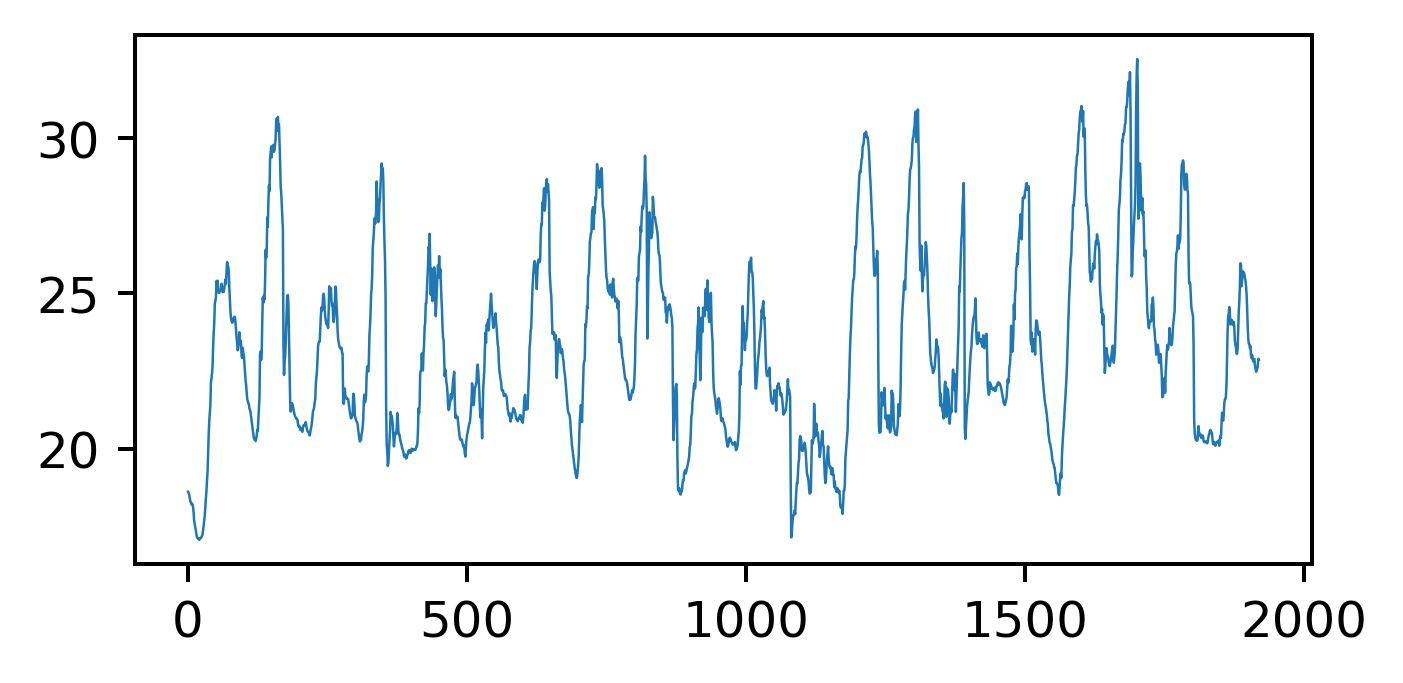

In [6]:
plot(series)

Não achei só um corte, escolhendo corte que gera maior pontuação, 1634, 683.5525588636692, 0, 5


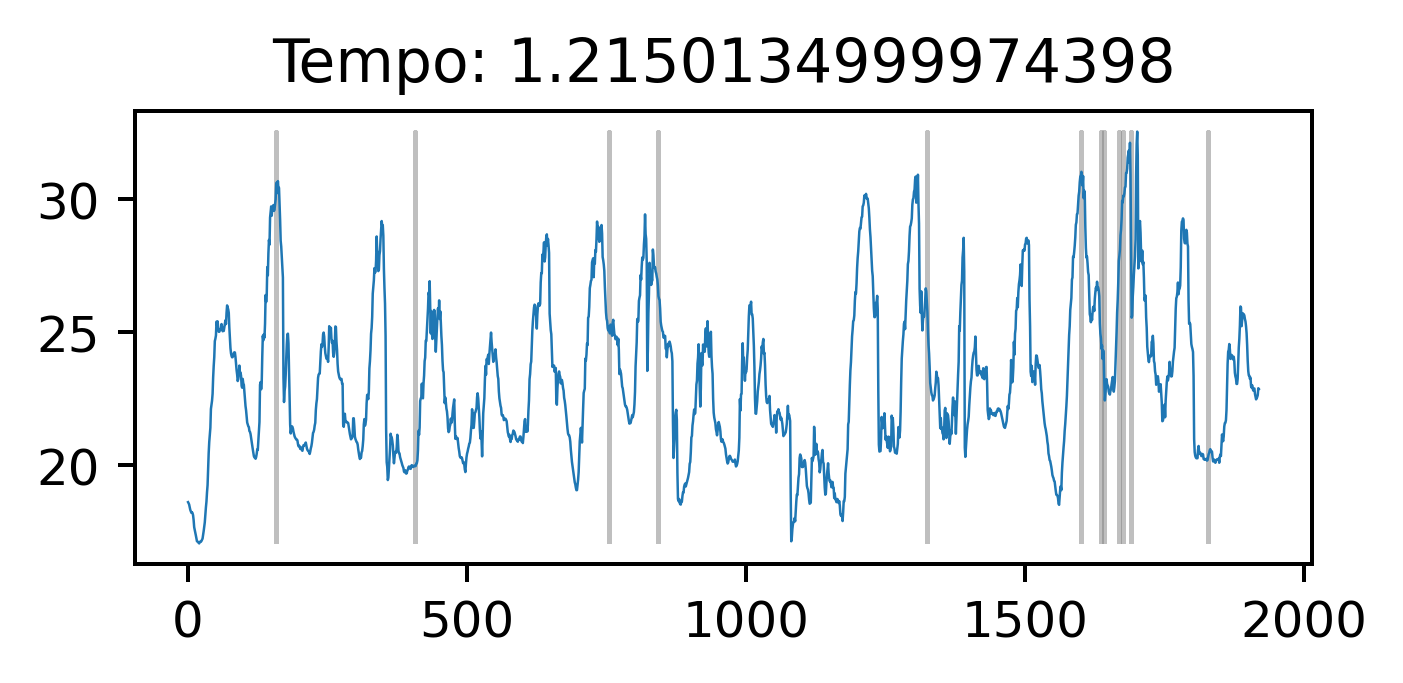

In [7]:
t = perf_counter()
ph_model = XTSTreePageHinkley(stop_condition='adf', stop_val=0.5, max_iter=100, min_dist=0)
ph_model = ph_model.create_splits(series)
plot(np.array(series), divisions=ph_model.cut_points(), title=f'Tempo: {perf_counter() - t}')
segments_page_hinkley = ph_model.cut_series(series)

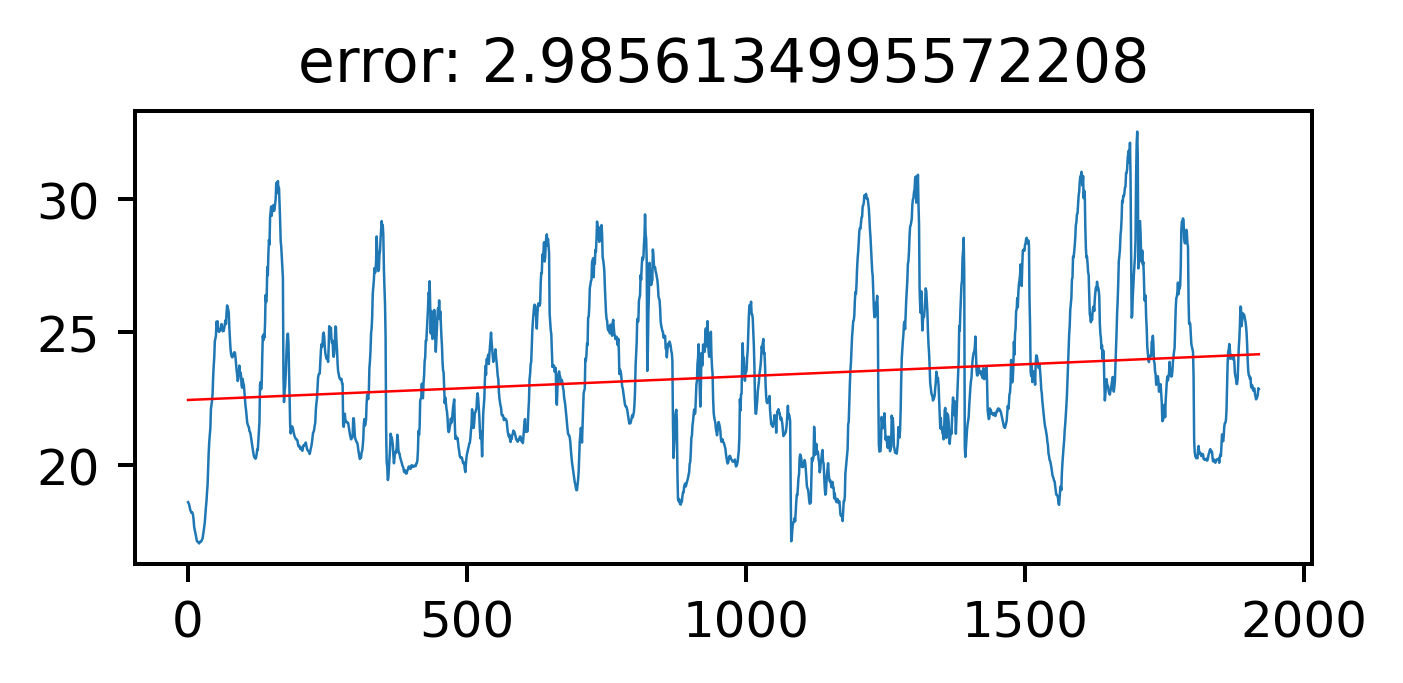

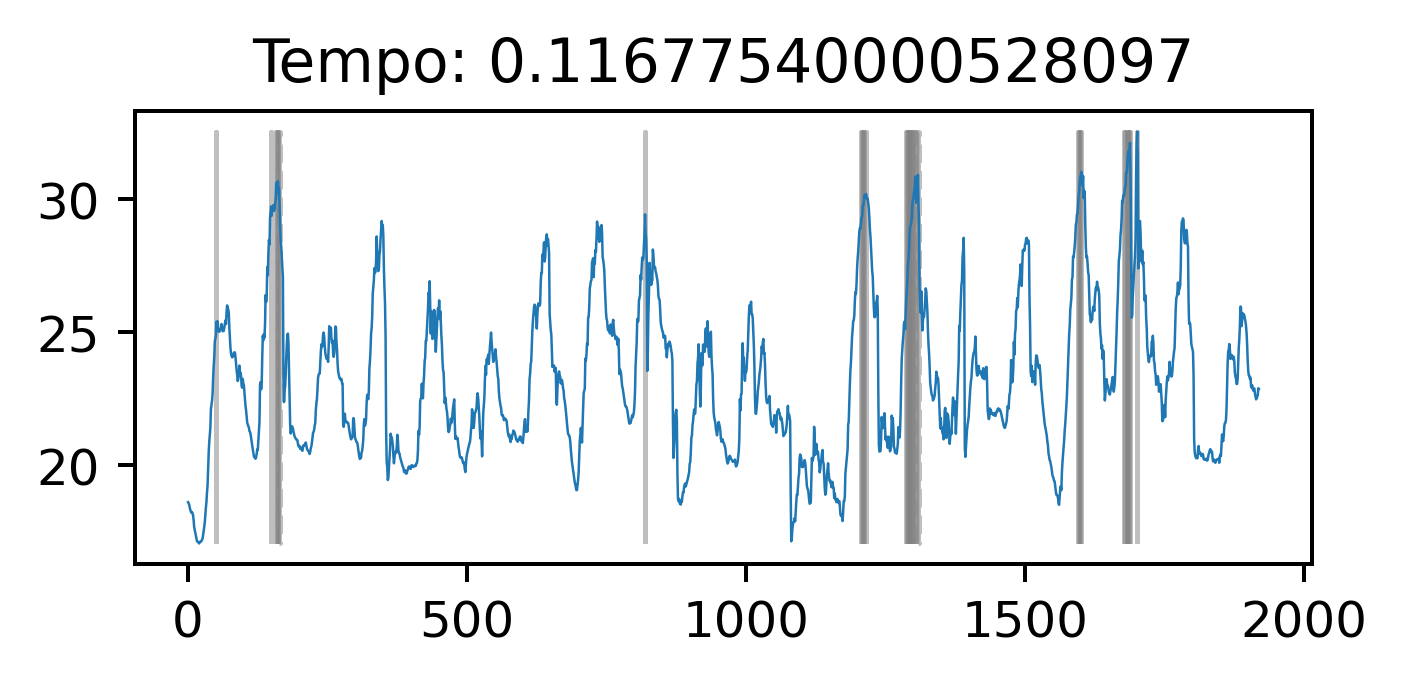

In [8]:
m_model, _, _, _ = apply_lr(np.arange(len(series)), series)
yhat = m_model.predict(np.arange(len(series)).reshape(-1, 1))
error = rmse(series, yhat)
plot(series, sec_plots=[yhat], title=f'error: {error}')

t = perf_counter()
tdi_model = XTSTreeTopDownIndex(stop_val=2.5, max_iter=100, min_dist=0)
tdi_model = tdi_model.create_splits(series)
plot(series, divisions=tdi_model.cut_points(), title=f'Tempo: {perf_counter() - t}')
segments_tdi = tdi_model.cut_series(series)

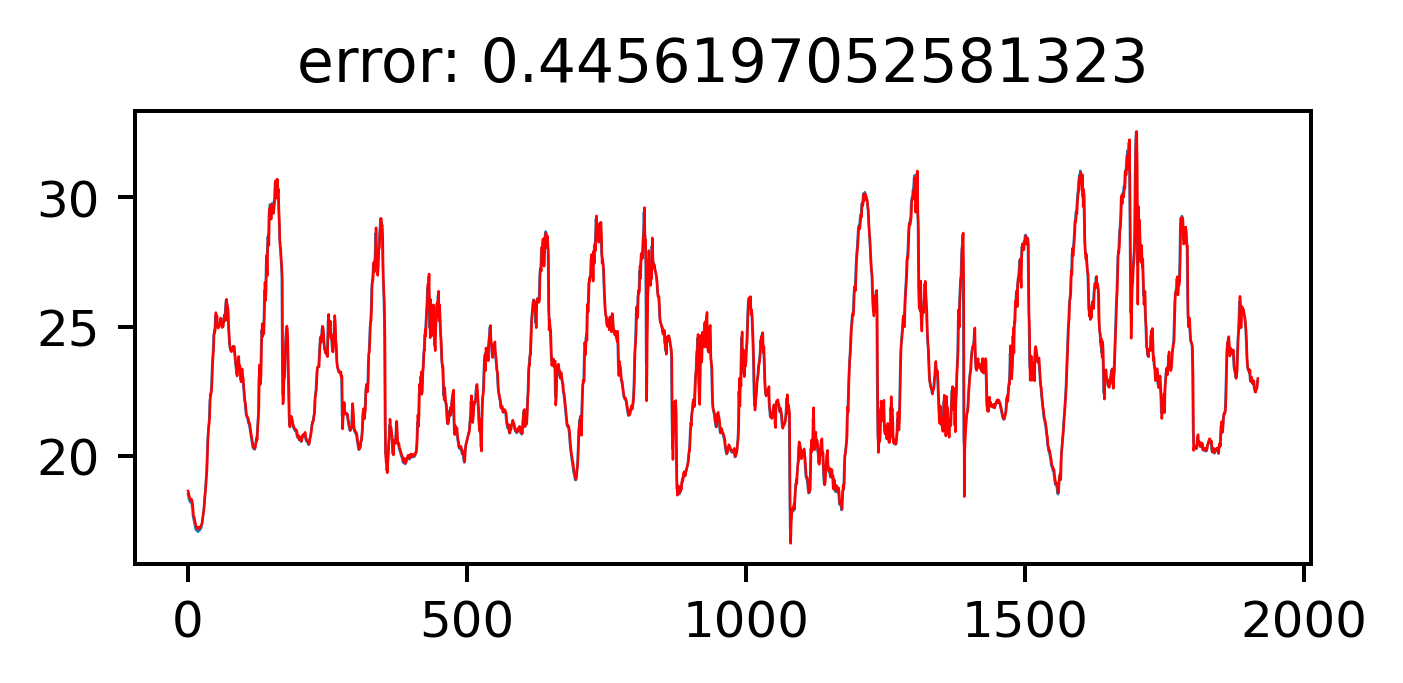

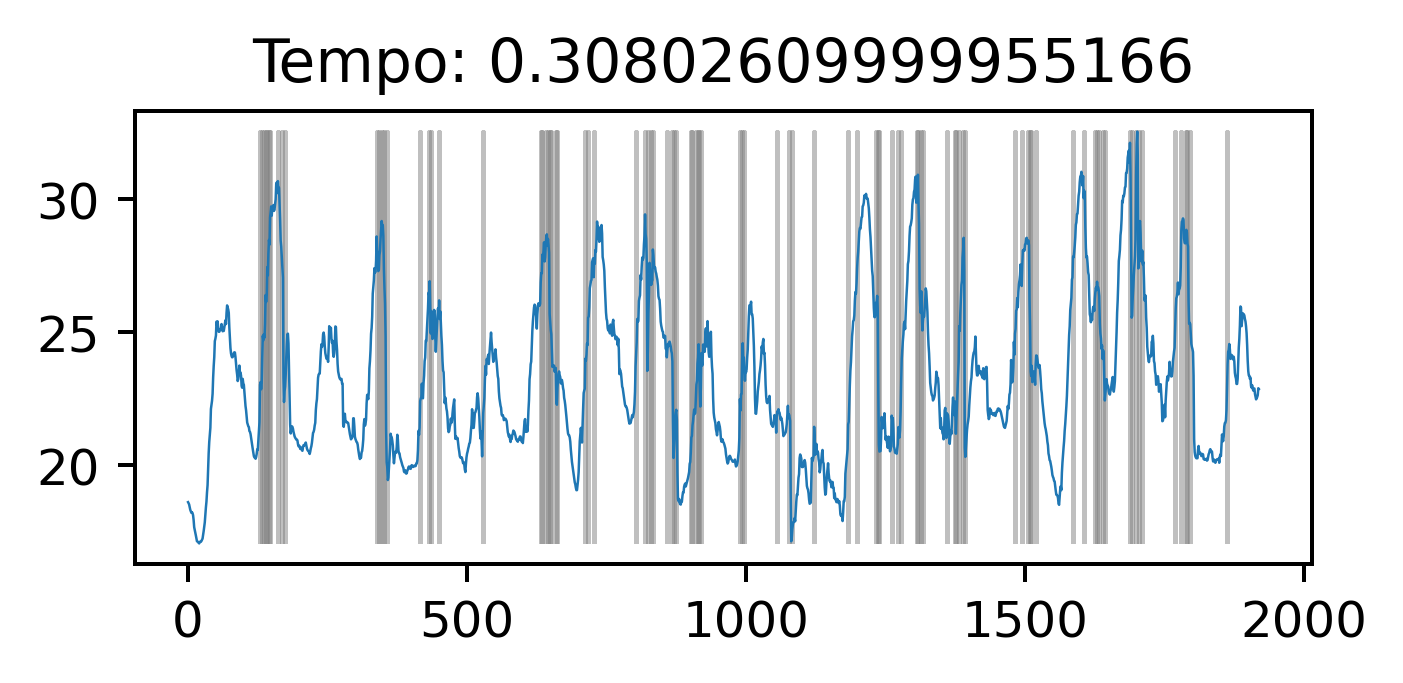

In [9]:
lag = 2

X, y = group_data(series, lag)
m_model, _, _, _ = apply_lr(X, y)
yhat = m_model.predict(X)
error = rmse(series[lag:], yhat)
plot(series[lag:], sec_plots=[yhat], title=f'error: {error}')

t = perf_counter()
tdr_model = XTSTreeTopDownReg(stop_val=0.3, max_iter=100, min_dist=0, lag=lag)
tdr_model = tdr_model.create_splits(series)
plot(series, divisions=tdr_model.cut_points(), title=f'Tempo: {perf_counter() - t}')
segments_tdr = tdr_model.cut_series(series)

In [10]:
from pysr import *

In [11]:
from pysr import *
def get_regressor(
    criteria,
    output_file,
    pop_n,
    pop_size,
    iterations,
    max_complexity=20,
    binary_operators=['+', '-', '*', '/', 'pow'],
    unary_operators=['sqrt', 'sin'],
    constraints=None,
    verbosity=0,
    early_stop_condition=None
   ):
  """
  constraints é um dicionário com os operadores unários e binários e uma tupla com a complexidade máxima dos argumentos.
  ver o que o should_simplify faz, aparentemente simplifica a equação, mas ver como ele faz isso
  usar random_state pra garantir mesmos resultados
  """
  return PySRRegressor(
    binary_operators=binary_operators,
    unary_operators=unary_operators,
    maxsize=max_complexity,
    niterations=iterations,
    populations=pop_n,
    population_size=pop_size,
    progress=False,
    model_selection=criteria,
    equation_file=f'./symbreg_objects/{output_file}.csv',
    verbosity = verbosity,
    temp_equation_file=False,
    early_stop_condition=early_stop_condition
  )

In [12]:
criteria='accuracy'
pop_n=5
pop_size=20
iterations=30
max_complexity=30

In [13]:
output = []
for rep in range(20):
  modelo = get_regressor(
    criteria=criteria,
    output_file='teste',
    pop_n=pop_n,
    pop_size=pop_size,
    iterations=iterations,
    max_complexity=max_complexity,
  )
  t = perf_counter()
  modelo.fit([[i] for i in range(len(series))], series)
  end_t = perf_counter() - t

  prediction_full = modelo.predict(np.array([[i] for i in range(len(series))]))
  complexity_full = modelo.get_best()["complexity"]

  output.append({
    'nome': f'Full_{rep}',
    'MAE (erro entre a série inteira e a predição de todos os segmentos)': mae(series, prediction_full),
    'RMSE (erro entre a série inteira e a predição de todos os segmentos)': rmse(series, prediction_full),
    'complexidade (média dos segmentos)': complexity_full,
    'desvio padrão complexidade': 0,
    'criteria': criteria,
    'pop_n': pop_n,
    'pop_size': pop_size,
    'iterations': iterations,
    'max_complexity': max_complexity,
    'tempo': end_t,
    'numero de segmentos': 1,
  })
  pd.DataFrame(output).to_csv('./resultados.csv', index=False)
  for segments, name in [(segments_page_hinkley, 'Page-hinkley'), (segments_tdi, 'Top-down index'), (segments_tdr, 'Top-down regression')]:
    y_hat = []
    complexities = []
    time = perf_counter()
    for segment in segments:
      modelo = get_regressor(
        criteria=criteria,
        output_file='teste',
        pop_n=pop_n,
        pop_size=pop_size,
        iterations=iterations,
        max_complexity=max_complexity,
      )
      modelo.fit([[i] for i in range(len(segment))], segment)

      prediction = modelo.predict(np.array([[i] for i in range(len(segment))]))
      y_hat = y_hat + list(prediction)
      complexities.append(modelo.get_best()["complexity"])
    end_t = perf_counter() - time

    output.append({
      'nome': f'{name}_{rep}',
      'MAE (erro entre a série inteira e a predição de todos os segmentos)': mae(series, y_hat),
      'RMSE (erro entre a série inteira e a predição de todos os segmentos)': rmse(series, y_hat),
      'complexidade (média dos segmentos)': np.mean(complexities),
      'desvio padrão complexidade': np.std(complexities),
      'criteria': criteria,
      'pop_n': pop_n,
      'pop_size': pop_size,
      'iterations': iterations,
      'max_complexity': max_complexity,
      'tempo': end_t,
      'numero de segmentos': len(segments),
    })
    pd.DataFrame(output).to_csv('./resultados.csv', index=False)

ValueError: Failed to evaluate the expression. If you are using a custom operator, make sure to define it in `extra_sympy_mappings`, e.g., `model.set_params(extra_sympy_mappings={'inv': lambda x: 1/x})`, where `lambda x: 1/x` is a valid SymPy function defining the operator. You can then run `model.refresh()` to re-load the expressions.

In [ ]:
resultados = pd.read_csv('resultados.csv')
resultados

,nome,MAE (Erro entre a série inteira e a predição de todos os segmentos),RMSE (Erro entre a série inteira e a predição de todos os segmentos),Complexidade (Média dos segmentos),criteria,pop_n,pop_size,iterations,max_complexity (Parâmetro usado para ),tempo,numero de segmentos
0,full,2.086554,2.625256,11.000000,accuracy,5,20,30,30,19.291478,1
1,Page-hinkley_0,1.280352,1.752055,25.461538,accuracy,5,20,30,30,30.440559,13
